In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import math

In [5]:
data = pd.read_csv('Midterm_53_group.csv')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Data Usage']])

# Split into train-test sets
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

print("Training data size:", len(train))
print("Testing data size:", len(test))

In [6]:
print("Dataset Preview:")
print(data.head())


Dataset Preview:
       Time           Source  No.      Destination Protocol  Length  \
0  0.000000    192.167.8.166    1  192.167.255.255     NBNS      92   
1  0.784682    192.167.8.166    2  192.167.255.255     NBNS      92   
2  1.169060  VMware_8a:5c:e6    3        Broadcast      ARP      60   
3  2.167949  VMware_8a:5c:e6    4        Broadcast      ARP      60   
4  3.170095  VMware_8a:5c:e6    5        Broadcast      ARP      60   

                                      Info  
0                   Name query NB WPAD<00>  
1                   Name query NB WPAD<00>  
2  Who has 192.167.7.175? Tell 192.167.0.1  
3  Who has 192.167.7.175? Tell 192.167.0.1  
4  Who has 192.167.7.175? Tell 192.167.0.1  


In [8]:
data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
data = data.dropna().reset_index(drop=True)

In [9]:
time = data['Time']
traffic = data['No.']

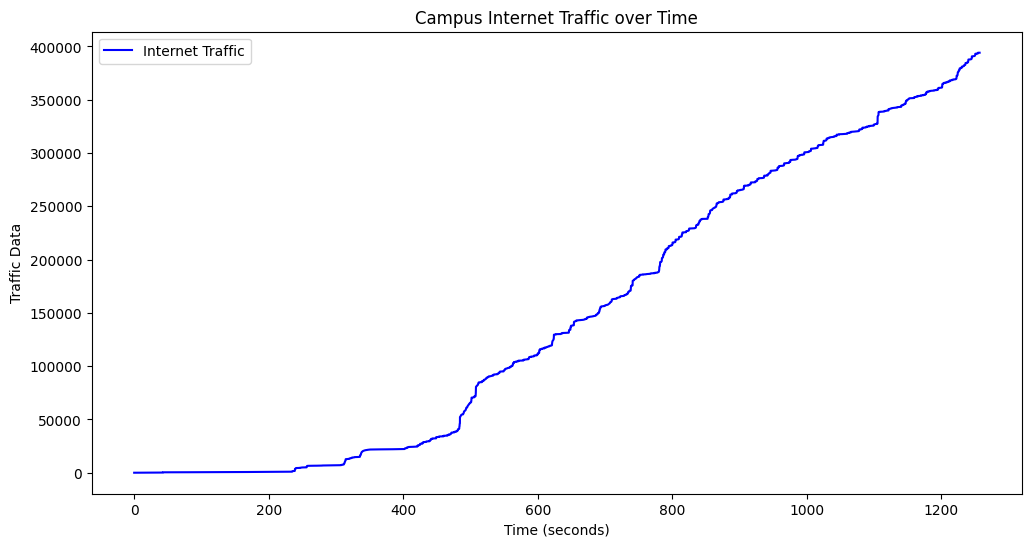

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(time, traffic, label="Internet Traffic", color='b')
plt.title("Campus Internet Traffic over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Traffic Data")
plt.legend()
plt.show()

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
traffic_scaled = scaler.fit_transform(traffic.values.reshape(-1, 1))

In [12]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [13]:
look_back = 10
X, Y = create_dataset(traffic_scaled, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [14]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [15]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
9854/9854 ━━━━━━━━━━━━━━━━━━━━ 155s 15ms/step - loss: 8.7484e-04
Epoch 2/20
9854/9854 ━━━━━━━━━━━━━━━━━━━━ 174s 12ms/step - loss: 2.4226e-06
Epoch 3/20
9854/9854 ━━━━━━━━━━━━━━━━━━━━ 144s 13ms/step - loss: 3.4869e-06
Epoch 4/20
5857/9854 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - loss: 1.4126e-06

In [ ]:
# Predict with LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [ ]:
# ARIMA Model
train_arima = traffic[:train_size]
test_arima = traffic[train_size:]

arima_model = ARIMA(train_arima, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

arima_pred = arima_model_fit.forecast(steps=len(test_arima))

In [ ]:
# Evaluate LSTM
lstm_rmse = math.sqrt(mean_squared_error(Y_test_inv, lstm_pred))
lstm_mae = mean_absolute_error(Y_test_inv, lstm_pred)

In [ ]:
# Evaluate ARIMA
arima_rmse = math.sqrt(mean_squared_error(test_arima, arima_pred))
arima_mae = mean_absolute_error(test_arima, arima_pred)

In [ ]:
# Print model performance
print("Model Performance Comparison:")
print(f"LSTM RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")
print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")

In [ ]:
# Visualization of predictions
plt.figure(figsize=(12, 6))
plt.plot(time[train_size + look_back:], Y_test_inv, label='Actual Traffic', color='g')
plt.plot(time[train_size + look_back:], lstm_pred, label='LSTM Predictions', color='b')
plt.plot(time[train_size:], arima_pred, label='ARIMA Predictions', color='r')
plt.title("Internet Traffic Forecast")
plt.xlabel("Time (seconds)")
plt.ylabel("Traffic Data")
plt.legend()
plt.show()